<a href="https://colab.research.google.com/github/ctrivino1/DroneAudioDataset/blob/master/Drone_Audio_ML.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Citing: 

@misc{Zenkov-sklearn-SER-basics,
  author = {Zenkov, Ilia},
  title = {sklearn-audio-classification},
  year = {2020},
  publisher = {GitHub},
  journal = {GitHub repository},
  howpublished = {\url{https://github.com/IliaZenkov/sklearn-audio-classification}},
}

@INPROCEEDINGS{AlEm1906:Audio,

AUTHOR=”Sara A Al-Emadi and Abdulla K Al-Ali and Abdulaziz Al-Ali and Amr Mohamed”,

TITLE=”Audio Based Drone Detection and Identification using Deep Learning”,

BOOKTITLE=”IWCMC 2019 Vehicular Symposium (IWCMC-VehicularCom 2019)”,

ADDRESS=”Tangier, Morocco”,

DAYS=23,

MONTH=jun,

YEAR=2019, }

# Clone the Repo with our audio data

In [ ]:
!git clone https://github.com/ctrivino1/DroneAudioDataset

fatal: destination path 'DroneAudioDataset' already exists and is not an empty directory.


# Import libraries

In [ ]:
# Get the critical imports out of the way
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import librosa.display
import soundfile
import os
# matplotlib complains about the behaviour of librosa.display, so we'll ignore those warnings:
import warnings; warnings.filterwarnings('ignore')
import datetime
%load_ext tensorboard
from tensorflow.python.keras.callbacks import TensorBoard
!pip install keras-rectified-adam
from keras_radam import RAdam
import tensorflow as tf
from tensorflow import keras
from keras import layers
from tensorflow.keras.applications import ResNet50
!pip install tensorflow_addons
import tensorflow_addons as tfa
from IPython.core.display import HTML 
import IPython.display as ipd
!pip install shap
import shap
# Center matplotlib figures...
HTML("""
<style>
.output_png {
    display: table-cell;
    text-align: center;
    vertical-align: middle;
}
</style>
""")

In [ ]:
## setting seed values 

# Seed value
# Apparently you may use different seed values at each stage
seed_value= 0

# 1. Set the `PYTHONHASHSEED` environment variable at a fixed value
os.environ['PYTHONHASHSEED']=str(seed_value)

# 2. Set the `python` built-in pseudo-random generator at a fixed value
import random
random.seed(seed_value)

# 3. Set the `numpy` pseudo-random generator at a fixed value
np.random.seed(seed_value)

# 4. Set the `tensorflow` pseudo-random generator at a fixed value
tf.random.set_seed(seed_value)
# for later versions: 
# tf.compat.v1.set_random_seed(seed_value)

# 5. Configure a new global `tensorflow` session
from keras import backend as K
session_conf = tf.compat.v1.ConfigProto(intra_op_parallelism_threads=1, inter_op_parallelism_threads=1)
sess = tf.compat.v1.Session(graph=tf.compat.v1.get_default_graph(), config=session_conf)
K.set_session(sess)
tf.compat.v1.keras.backend.set_session(sess)




# Random sound samples of our data. 

Our dataset has 3 different types of classes 2 of which belong to drones(bebop_1/membo_1) and the other are random sounds. We will now randomly pic out a sound sample from each of the classes and do some data exploration/preprocessing.

In [ ]:
print("Bebop_1 Sound Sample")
ipd.display(ipd.Audio('/content/DroneAudioDataset/Multiclass_Drone_Audio/bebop_1/bebop_ (1).wav'))
print("\n")
print("Membo_1 Sound Sample")
ipd.display(ipd.Audio('/content/DroneAudioDataset/Multiclass_Drone_Audio/membo_1/membo_ (1).wav'))
print("\n")
print("Unknown Sound Sample")
ipd.display(ipd.Audio('/content/DroneAudioDataset/Multiclass_Drone_Audio/unknown/unknown_ (100).wav'))



Bebop_1 Sound Sample




Membo_1 Sound Sample




Unknown Sound Sample


# visualizaing our Random samples





Bebop sample rate   :  16000
Membo sample rate   :  16000
Unknown sample rate :  16000


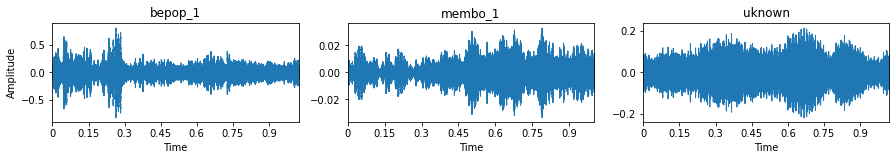

In [ ]:


################# different samples of sounds from each data set #####################################
# sampling rate is the samples per second
with soundfile.SoundFile('/content/DroneAudioDataset/Multiclass_Drone_Audio/bebop_1/bebop_ (1).wav') as audio:
    waveform = audio.read(dtype="float32") # ready the audio file as a floats
    sample_rate = audio.samplerate # every audio file comes with a given sample rate, but I could also specify a value
    plt.figure(figsize=(15,4))
    plt.subplot(2, 3, 1)
    librosa.display.waveplot(waveform, sr=sample_rate) # displays the specific wave file
    plt.title('bepop_1')
    plt.ylabel("Amplitude")
    print("Bebop sample rate   : ", sample_rate)
    #print(waveform)
    

with soundfile.SoundFile('/content/DroneAudioDataset/Multiclass_Drone_Audio/membo_1/membo_ (1).wav') as audio:
    waveform = audio.read(dtype="float32")
    sample_rate = audio.samplerate 
    plt.subplot(2, 3, 2)
    librosa.display.waveplot(waveform, sr=sample_rate)
    plt.title('membo_1')
    print("Membo sample rate   : ", sample_rate)
    

with soundfile.SoundFile('/content/DroneAudioDataset/Multiclass_Drone_Audio/unknown/unknown_ (100).wav') as audio:
    waveform = audio.read(dtype="float32")
    sample_rate = audio.samplerate
    plt.subplot(2, 3, 3)
    librosa.display.waveplot(waveform, sr=sample_rate)
    plt.title('uknown')
    print("Unknown sample rate : ", sample_rate)



We can see from these different samples that there are some differences but I would like to create more features that an A.N.N could train on. Hence from here on I will create features that will be used to train our final model

# Fast Fourier Transform 


The below plots are symmetrical at half of the sample rate(This is a property of the Fourier transform). But the information needed can be achieved by viewing the first half of the total samples. The code below has been modiefied to just look at the first half of the sample rate. 

note:  The FFt is helpful in looking at the amplitude of each sound, but amplitutude in and ofitself is not a strong enough feature for deep learning. We will continue to build on features after the FFT. 

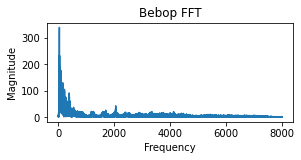

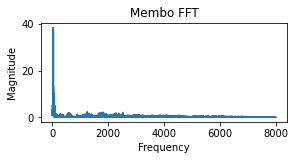

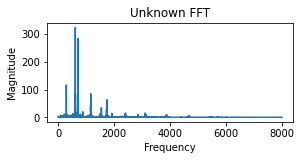

In [ ]:
with soundfile.SoundFile('/content/DroneAudioDataset/Multiclass_Drone_Audio/bebop_1/bebop_ (1).wav') as audio:
  waveform = audio.read(dtype="float32")
  sample_rate = audio.samplerate 
  plt.figure(figsize=(15,4))
  plt.subplot(2, 3, 1)
  fft = np.fft.fft(waveform) # gives me a numpy array that has as many values as the total number of samples I have in the wave form. But we want to find the magnitude of these values
  magnitude = np.abs(fft) 
  frequency = np.linspace(0,sample_rate, len(magnitude)) # The frequency interval we are considering, 
  # both of the vectors made above are telling us how much each frequency is contributing to the overall sound
  left_frequency = frequency[:int(len(frequency)/2)] # grabs the  frequncy up to half of the samples
  left_magnitude = magnitude[:int(len(frequency)/2)] # grabs the magnitude up to half of the samples
  plt.xlabel("Frequency")
  plt.ylabel("Magnitude")
  plt.title('Bebop FFT')
  plt.plot(left_frequency,left_magnitude)

with soundfile.SoundFile('/content/DroneAudioDataset/Multiclass_Drone_Audio/membo_1/membo_ (1).wav') as audio:
  waveform = audio.read(dtype="float32")
  sample_rate = audio.samplerate 
  plt.figure(figsize=(15,4))
  plt.subplot(2, 3, 2)
  fft = np.fft.fft(waveform) # gives me a numpy array that has as many values as the total number of samples I have in the wave form. But we want to find the magnitude of these values
  magnitude= np.abs(fft) 
  frequency = np.linspace(0,sample_rate, len(magnitude)) # The frequency interval we are considering
  # both of the vectors made above are telling us how much each frequency is contributing to the overall sound
  left_frequency = frequency[:int(len(frequency)/2)] # grabs the  frequncy up to half of the samples
  left_magnitude = magnitude[:int(len(frequency)/2)] # grabs the magnitude up to half of the samples
  plt.title('Membo FFT')
  plt.xlabel("Frequency")
  plt.ylabel("Magnitude")
  plt.plot(left_frequency,left_magnitude)

with soundfile.SoundFile('/content/DroneAudioDataset/Multiclass_Drone_Audio/unknown/unknown_ (100).wav') as audio:
  waveform = audio.read(dtype="float32")
  sample_rate = audio.samplerate
  plt.figure(figsize=(15,4))
  plt.subplot(2, 3, 3)
  fft = np.fft.fft(waveform) # gives me a numpy array that has as many values as the total number of samples I have in the wave form. But we want to find the magnitude of these values
  magnitude = np.abs(fft) 
  frequency = np.linspace(0,sample_rate, len(magnitude)) # The frequency interval we are considering
  # both of the vectors made above are telling us how much each frequency is contributing to the overall sound
  left_frequency = frequency[:int(len(frequency)/2)] # grabs the  frequncy up to half of the samples
  left_magnitude = magnitude[:int(len(frequency)/2)] # grabs the magnitude up to half of the samples
  plt.title('Unknown FFT')
  plt.xlabel("Frequency")
  plt.ylabel("Magnitude")
  plt.plot(left_frequency,left_magnitude)


As you can see most of the energey is concentrated in the lower frequencies. 

Important: The FFt visualization shows a static snapshot of the whole sound. But what we want to understand is how these frequencies are contributing to the overall sound throughout time. In order to do this we will create an STFT.

# Short-Time Fourier Transform

Fourtier Transforms allow us to understand complex sounds and understand how different frequences are contributing to our sound waves

What does STFT do? :     



*   Computes Several FTT at different intervals
*   Preserves "time" (x-axis) information
*   Gives a spectrogramt(time + frequency + magnitute)
*   Fixed frame size(# of samples, ex: 2048 samples)

This helps to give us information about the magnitude of the sound wave as a function of frequency and time. 



So the STFT takes us from the first visualizations shown above where we are just looking at the magnitude of the wave at a given time based on the sample rate to --> calculating how many "Hz" is present in the sound at a given time. 

In [ ]:
with soundfile.SoundFile('/content/DroneAudioDataset/Multiclass_Drone_Audio/bebop_1/bebop_ (1).wav') as audio:
    bebop_1_waveform = audio.read(dtype="float32")
    sample_rate = audio.samplerate

with soundfile.SoundFile('/content/DroneAudioDataset/Multiclass_Drone_Audio/membo_1/membo_ (1).wav') as audio:
    membo_1_waveform = audio.read(dtype="float32")
    sample_rate = audio.samplerate


with soundfile.SoundFile('/content/DroneAudioDataset/Multiclass_Drone_Audio/unknown/unknown_ (100).wav') as audio:
    Unknown_waveform = audio.read(dtype="float32")
    sample_rate = audio.samplerate

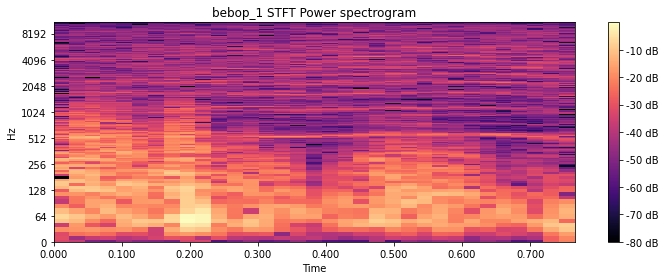

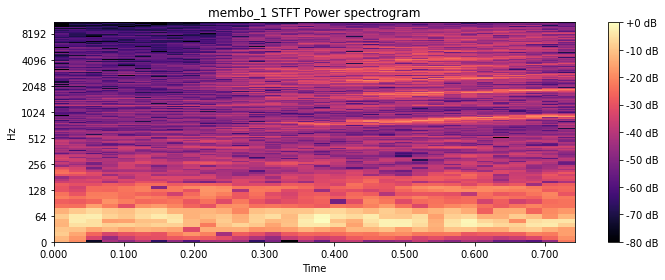

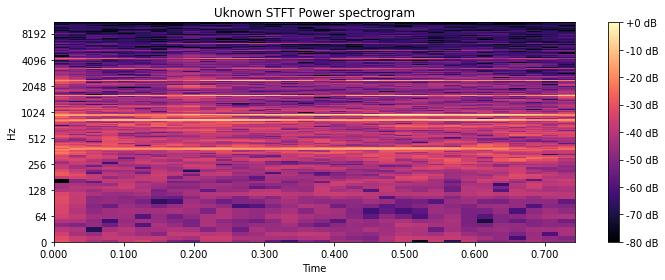

In [ ]:
# Visualize the combination of power spectrograms output by STFT w.r.t time

stft_spectrum_matrix = librosa.stft(bebop_1_waveform)
plt.figure(figsize=(10, 4))
librosa.display.specshow(librosa.amplitude_to_db(np.abs(stft_spectrum_matrix), ref=np.max),y_axis='log', x_axis='time')
plt.title('bebop_1 STFT Power spectrogram')
plt.colorbar(format='%+2.0f dB')
plt.tight_layout()

stft_spectrum_matrix = librosa.stft(membo_1_waveform)
plt.figure(figsize=(10, 4))
librosa.display.specshow(librosa.amplitude_to_db(np.abs(stft_spectrum_matrix), ref=np.max),y_axis='log', x_axis='time')
plt.title('membo_1 STFT Power spectrogram')
plt.colorbar(format='%+2.0f dB')
plt.tight_layout()

stft_spectrum_matrix = librosa.stft(Unknown_waveform)
plt.figure(figsize=(10, 4))
librosa.display.specshow(librosa.amplitude_to_db(np.abs(stft_spectrum_matrix), ref=np.max),y_axis='log', x_axis='time')
plt.title('Uknown STFT Power spectrogram')
plt.colorbar(format='%+2.0f dB')
plt.tight_layout()

Note: for the visualizations above, the color is helping us find how much a given "Hz" is present in the sound at a given time. 

Note: **I am operating under the assumption that features whose interclass differences we can visualize will be good candidates on which to train a neural network**

# Mel-Frequency Cepstral Coefficients(MFCC's)

##### We're going to build on the STFT by using the Mel Frequency Cepstral Coefficients (MFCCs) as a feature. In brief, MFCC is a mathematical method which transforms the power spectrum of an audio signal to a small number of coefficients representing power of the audio signal in a frequency region (a region of pitch) taken w.r.t. time.

In other words, MFC coefficients give us an idea of the changing pitch of an audio signal.



# MFCC's

Basics of what MFCC does:


*   Capture timbral/textural aspects of sound
*   Frequency domain feature
* Approximate the human auditory system: meaning the mel spectrograms try to model the way we(humans) percieve frequency
*   13 to 40 coefficients at each frame
*   calculated at each frame 



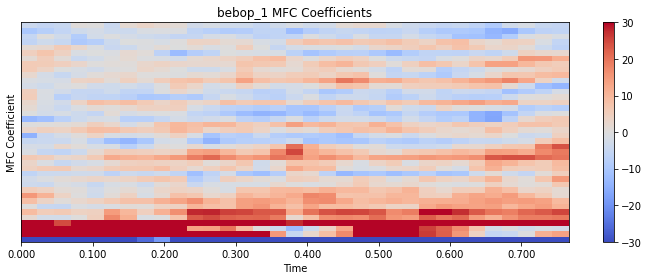

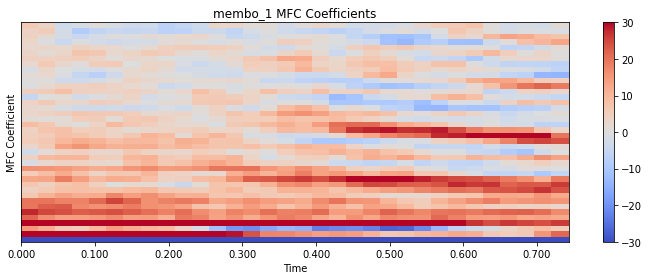

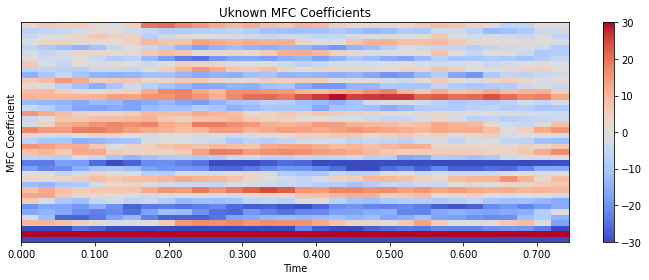

In [ ]:
## visualize our samples MFC coefficients w.r.t time

from matplotlib.colors import Normalize
mfc_coefficients = librosa.feature.mfcc(y=bebop_1_waveform, sr=sample_rate, n_mfcc=40) # we are using 40 mfc coefficients.
plt.figure(figsize=(10, 4))
librosa.display.specshow(mfc_coefficients, x_axis='time',norm=Normalize(vmin=-30,vmax=30))
plt.colorbar()
plt.yticks(())
plt.ylabel('MFC Coefficient')
plt.title('bebop_1 MFC Coefficients')
plt.tight_layout()
                                        
mfc_coefficients = librosa.feature.mfcc(y=membo_1_waveform, sr=sample_rate, n_mfcc=40)
plt.figure(figsize=(10, 4))
librosa.display.specshow(mfc_coefficients, x_axis='time',norm=Normalize(vmin=-30,vmax=30))
plt.colorbar()
plt.yticks(())
plt.ylabel('MFC Coefficient')
plt.title('membo_1 MFC Coefficients')
plt.tight_layout()

mfc_coefficients = librosa.feature.mfcc(y=Unknown_waveform, sr=sample_rate, n_mfcc=40)
plt.figure(figsize=(10, 4))
librosa.display.specshow(mfc_coefficients, x_axis='time',norm=Normalize(vmin=-30,vmax=30))
plt.colorbar()
plt.yticks(())
plt.ylabel('MFC Coefficient')
plt.title('Uknown MFC Coefficients')
plt.tight_layout()

These visualizations have the MFC coefficients on the Y-axis. The value of the coefficents is represented by the color. The more red the higher the MFC coefficient. 



**Positive MFCCs correspond to low-frequency regions of the cepstrum, and negative MFFCs to high-frequency.**

**In these samples we can see that the membo and bebop class both are correlated with higher MFFC proportion**

# Mel Spectrograms and Mel-Frequency Cepstrums

#### Mel Spectrograms and Mel-Frequency Cepstrums

#### In deriving our MFCCs, we have also produced an additional feature we can make use of. When we mapped the frequencies of a power spectrogram to the mel scale, we produced a Mel Frequency Spectrogram - a simple analog of the power spectrogram with the frequency scale in mels. We're going to use the Mel Specotrgrogram as a feature of its own.

Visualize our sample's Mel spectrogram w.r.t time:

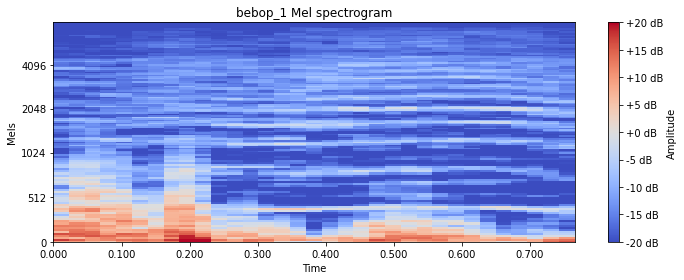

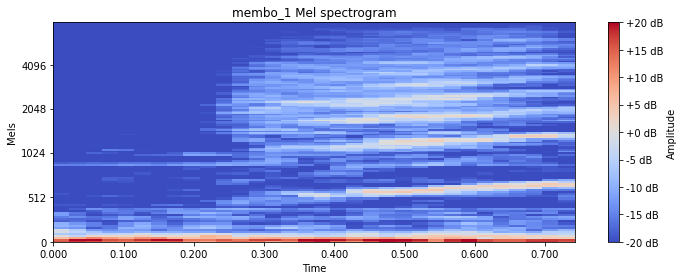

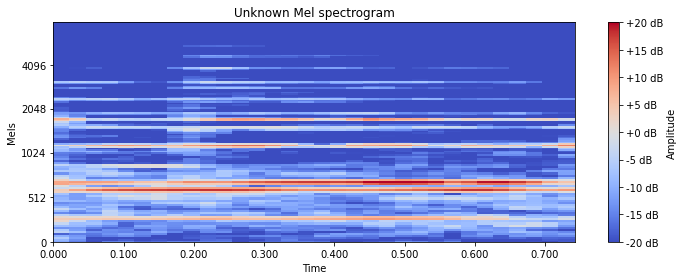

In [ ]:
melspectrogram = librosa.feature.melspectrogram(y=bebop_1_waveform, sr=sample_rate, n_mels=128, fmax=8000)
plt.figure(figsize=(10, 4))
librosa.display.specshow(librosa.power_to_db(S=melspectrogram, ref=np.mean),y_axis='mel',fmax=8000, x_axis='time', norm=Normalize(vmin=-20,vmax=20))
plt.colorbar(format='%+2.0f dB',label='Amplitude')
plt.ylabel('Mels')
plt.title('bebop_1 Mel spectrogram')
plt.tight_layout()

melspectrogram = librosa.feature.melspectrogram(y=membo_1_waveform, sr=sample_rate, n_mels=128, fmax=8000)
plt.figure(figsize=(10, 4))
librosa.display.specshow(librosa.power_to_db(S=melspectrogram, ref=np.mean),y_axis='mel',fmax=8000, x_axis='time', norm=Normalize(vmin=-20,vmax=20))
plt.colorbar(format='%+2.0f dB',label='Amplitude')
plt.ylabel('Mels')
plt.title('membo_1 Mel spectrogram')
plt.tight_layout()

melspectrogram = librosa.feature.melspectrogram(y=Unknown_waveform, sr=sample_rate, n_mels=128, fmax=8000)
plt.figure(figsize=(10, 4))
librosa.display.specshow(librosa.power_to_db(S=melspectrogram, ref=np.mean),y_axis='mel',fmax=8000, x_axis='time', norm=Normalize(vmin=-20,vmax=20))
plt.colorbar(format='%+2.0f dB',label='Amplitude')
plt.ylabel('Mels')
plt.title('Unknown Mel spectrogram')
plt.tight_layout()

**From these visualizations we see the different classes pitch transitions. This seems like it may be a useful feature in training a model** (Get Chiltons help for interpretation)

# The Chromagram

#### To extract an additional feature, we're going to build a chromagram on each power spectrogram computed by STFT. A chromagram is a representation of an audio signal w.r.t. time, mapping audio signal to a pitch class. Most often, we map to the 12 standard pitch classes (i.e. the musical scale CDEFGAB + 5 semitones gives us 12 pitch classes). Again, wikipedia has a short and sweet explanation. 

Visualize the Chromogram four our sample audio:

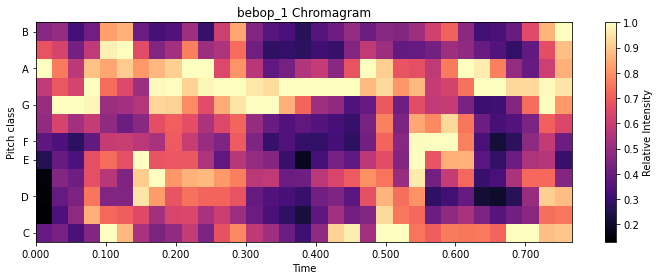

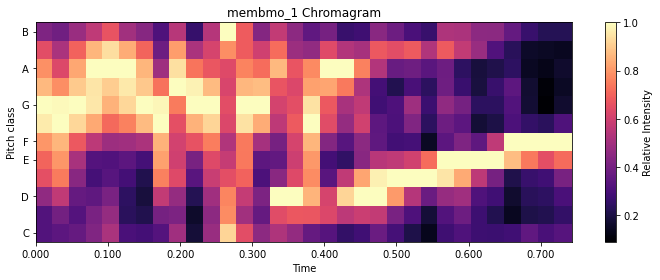

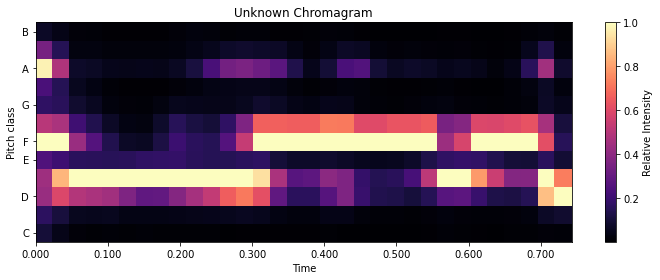

In [ ]:
chromagram = librosa.feature.chroma_stft(y=bebop_1_waveform, sr=sample_rate)
plt.figure(figsize=(10, 4))
librosa.display.specshow(chromagram, y_axis='chroma', x_axis='time')
plt.colorbar(label='Relative Intensity')
plt.title('bebop_1 Chromagram')
plt.tight_layout()

chromagram = librosa.feature.chroma_stft(y=membo_1_waveform, sr=sample_rate)
plt.figure(figsize=(10, 4))
librosa.display.specshow(chromagram, y_axis='chroma', x_axis='time')
plt.colorbar(label='Relative Intensity')
plt.title('membmo_1 Chromagram')
plt.tight_layout()

chromagram = librosa.feature.chroma_stft(y=Unknown_waveform, sr=sample_rate)
plt.figure(figsize=(10, 4))
librosa.display.specshow(chromagram, y_axis='chroma', x_axis='time')
plt.colorbar(label='Relative Intensity')
plt.title('Unknown Chromagram')
plt.tight_layout()

**Here we can look at the different dispersion rates of our sample from the classes, there are some interesting patterns** (get chiltons help for more interpretation)

# Feature Extraction

We're going to take full advantage of librosa, a Python library enabling audio analysis and feature extraction. Librosa abstracts away all the math and most of the details of mel spectrorgams, chromagrams, and MFCC. Although closely related, we're going to take the Mel Spectrogram, MFCC, and chromagrams of each audio file as separate features to try and have bit more discriminatory power between samples.

Let's build our feature extraction functions to get a chromagram, a mel spectorgram, and MFC coefficients for each of our audio files. Because the chromagram, mel spectrogram and MFCCs are calculated on audio frames produced by STFT, we're going to get a matrix back from each function, so we'll take the mean of those matrices to produce a single feature array for each feature and each audio sample, i.e. 3 feature arrays per audio sample.

**Chromagram**: Will produce 12 features; One for each of 12 pitch classes

**Mel Spectrogram**: Will produce 128 features; We've defined the number of mel frequency bands at n_mels=128

**MFCC:** Will produce 40 MFCCs; I've set the number of coefficients to return at n_mfcc=40 which I found to work well


In [ ]:
import librosa

def feature_chromagram(waveform, sample_rate):
    # STFT computed here explicitly; mel spectrogram and MFCC functions do this under the hood
    stft_spectrogram=np.abs(librosa.stft(waveform))
    # Produce the chromagram for all STFT frames and get the mean of each column of the resulting matrix to create a feature array
    chromagram=np.mean(librosa.feature.chroma_stft(S=stft_spectrogram, sr=sample_rate).T,axis=0)
    return chromagram

def feature_melspectrogram(waveform, sample_rate):
    # Produce the mel spectrogram for all STFT frames and get the mean of each column of the resulting matrix to create a feature array
    # Using 8khz as upper frequency bound should be enough for most speech classification tasks
    melspectrogram=np.mean(librosa.feature.melspectrogram(y=waveform, sr=sample_rate, n_mels=128, fmax=8000).T,axis=0)
    return melspectrogram

def feature_mfcc(waveform, sample_rate):
    # Compute the MFCCs for all STFT frames and get the mean of each column of the resulting matrix to create a feature array
    # 40 filterbanks = 40 coefficients
    mfc_coefficients=np.mean(librosa.feature.mfcc(y=waveform, sr=sample_rate, n_mfcc=40).T, axis=0) 
    return mfc_coefficients

We're going to wrap our feature extraction functions so we only have to load each audio file once. After extracting our 3 audio features as NumPy arrays representing a time series, we're going to stack them horizontally to create a single feature array.

In [ ]:
def get_features(file):
    # load an individual soundfile
     with soundfile.SoundFile(file) as audio:
        waveform = audio.read(dtype="float32")
        sample_rate = audio.samplerate
        # compute features of soundfile
        chromagram = feature_chromagram(waveform, sample_rate)
        melspectrogram = feature_melspectrogram(waveform, sample_rate)
        mfc_coefficients = feature_mfcc(waveform, sample_rate)

        feature_matrix=np.array([])
        # use np.hstack to stack our feature arrays horizontally to create a feature matrix
        feature_matrix = np.hstack((chromagram, melspectrogram, mfc_coefficients))
        
        return feature_matrix

In [ ]:
#Emotions in the RAVDESS dataset

classes ={
  'bebop':'bebop_1',
  'membo':'membo_1',
  'unknown':'unknown',
}

Load our data set (Need lots of help)

In [ ]:
import os, glob
## my filepath examples


def load_data():
    X,y=[],[]
    count = 0
    for file in glob.glob("/content/DroneAudioDataset/Multiclass_Drone_Audio//*//*.wav"):
        file_name=os.path.basename(file)
        clas=classes[file_name.split("_")[0]]
        features = get_features(file)
        X.append(features)
        y.append(clas)
        count += 1
        # '\r' + end='' results in printing over same line
        print('\r' + f' Processed {count}/{11704} audio samples',end=' ')
    # Return arrays to plug into sklearn's cross-validation algorithms
    return np.array(X), np.array(y)

In [ ]:
features, classes = load_data()

 Processed 11704/11704 audio samples 

In [ ]:
print(f'\nAudio samples represented: {features.shape[0]}')
print(f'Numerical features extracted per sample: {features.shape[1]}')
features_df = pd.DataFrame(features) # make it pretty for display
features_df


Audio samples represented: 11704
Numerical features extracted per sample: 180


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179
0,0.594143,0.639976,0.640830,0.590937,0.628389,0.657189,0.724161,0.817875,0.798693,0.792062,0.615101,0.595803,6.507245,36.731213,16.627989,5.513922,2.245294,2.206916,1.938595,0.820152,0.409017,0.317071,0.237993,0.222568,0.183590,0.187330,0.415308,0.428163,1.536514,0.777713,0.755163,0.108044,0.016088,0.015142,0.038798,0.046600,0.132668,0.037136,0.008443,0.020945,...,-129.676331,15.719725,3.798151,35.867882,14.471816,24.340919,9.327422,10.683431,6.172061,4.994376,-1.252673,3.592732,-1.321934,7.586447,4.182318,14.991236,10.576593,7.705986,-2.358572,-0.269654,3.757990,3.623745,-2.741435,-5.025840,-5.546183,1.279980,-2.804305,1.213429,-0.415709,3.248299,-0.267020,1.955489,4.225486,4.371250,2.776349,1.340867,-3.499661,-4.938687,-6.663528,-3.483768
1,0.664225,0.717549,0.707007,0.637622,0.750741,0.641173,0.728841,0.861372,0.852142,0.969532,0.736179,0.716133,54.896057,169.159225,79.097900,44.744907,14.152336,10.633640,7.473721,2.929775,2.422397,2.076967,2.011820,1.850444,1.097919,0.583869,0.515587,0.946175,2.772183,2.415687,0.499373,0.096293,0.076903,0.059813,0.081922,0.169932,0.162324,0.078015,0.045512,0.036597,...,-58.910831,14.736643,1.977886,38.288635,18.965979,24.414906,12.137589,17.551220,13.733078,9.221336,0.955522,2.610270,-3.948850,7.183711,5.512191,17.375830,11.526914,6.275281,-4.471828,-2.695804,0.952728,1.399976,-4.042207,-1.889341,-1.949773,3.483492,-3.399974,-0.097900,0.048874,2.946249,1.834929,4.576199,3.259195,-0.002514,2.893973,2.233961,-6.953228,-7.693705,-6.439998,-5.754591
2,0.701121,0.717701,0.594807,0.636623,0.686130,0.696124,0.749650,0.793785,0.830644,0.935307,0.713674,0.645816,3.983562,14.924697,8.496207,3.671690,1.781876,0.731693,0.455412,4.170687,5.147472,0.556729,0.261457,0.413077,1.279540,0.114582,0.455747,0.504813,0.205965,0.497298,0.975359,0.145673,0.161782,0.142619,0.060390,0.074551,0.069474,0.044461,0.039617,0.042091,...,-117.903564,31.710464,9.511106,32.282742,7.693764,17.737921,8.012018,10.407883,3.393224,0.014047,-2.988333,0.403827,-5.001854,6.842463,4.633149,10.122624,-1.097315,-0.369759,-1.765677,1.088477,-0.423385,-1.546614,-1.443458,5.147111,0.825230,0.477768,-2.119169,10.254724,4.978828,-2.290603,-1.782257,3.349134,0.058280,0.608637,7.542167,3.225703,-7.188931,-2.025248,0.223986,0.089417
3,0.493674,0.538583,0.742738,0.784044,0.569341,0.931958,0.751835,0.549893,0.529016,0.727722,0.650305,0.513001,0.297761,0.881230,0.201277,0.043674,0.028904,0.146648,0.138837,0.033617,0.041771,0.045894,0.043194,0.319542,0.215977,0.112861,0.244984,0.184129,0.224489,0.395583,0.527889,0.279974,0.057308,0.050735,0.041739,0.055373,0.741347,12.799188,2.071025,0.214567,...,-119.482719,21.494308,-16.216366,8.075471,-14.127222,-2.961745,-10.104506,1.050462,5.286402,10.319860,8.494123,9.187192,-4.528800,-3.540831,-11.263555,4.988850,6.992200,10.125459,8.281113,9.708523,8.123207,1.909561,-3.001792,-2.046826,-8.599874,-4.650934,1.806994,14.346951,5.367188,-1.992197,-3.179407,2.987068,1.156963,-3.212732,-0.257643,1.737331,-0.159324,0.099861,-1.739792,0.593385
4,0.652761,0.718873,0.722777,0.689233,0.621067,0.677629,0.833028,0.944856,0.887855,0.674077,0.677412,0.655475,22.012089,88.222198,71.569000,28.456024,27.801744,15.681381,17.615576,7.664920,6.229872,2.364656,2.207687,1.515272,0.830482,0.564277,0.602885,2.352278,2.854282,1.902992,0.639463,0.112414,0.077732,0.076401,0.085595,0.095717,0.064494,0.036650,0.060246,0.062392,...,-73.718277,3.250217,-9.807632,28.230667,8.266650,20.478069,9.487748,11.013824,7.472511,7.166858,0.938833,2.966870,-3.578007,5.866893,7.982062,21.572773,17.324287,10.276776,-5.098617,-5.490232,3.725077,7.250066,-3.517064,-7.990360,-4.889964,5.229215,-2.830894,-2.962224,-2.309122,7.328297,4.370045,3.321266,6.539835,2.992534,-2.527587,-2.15

In [ ]:
import altair as alt
alt.data_transformers.disable_max_rows()

c = pd.DataFrame(classes,columns=["classes"])

bars = alt.Chart(c).mark_bar().encode(
    alt.Y("classes",sort="-y"),
    alt.X("count(classes)",title="Class count")
    )

text = bars.mark_text(
    align='left',
    baseline='middle',
    dx=3  # Nudges text to right so it doesn't appear on top of the bar
).encode(
    text='count():Q'
)

(bars + text)

alt.LayerChart(...)

As you can see there is not an equal amount of the classes in our dataset. We may have to use some oversampling techniques to help with this later. 

#Feature scaling


Lets take a look at our features distributions, then we can decide whther to use min max scaling or standard scalart to help with some feature scaling

In [ ]:
# We would usually use df.describe(), but it provides a bit of a mess of information we don't need at the moment.
def print_features(df):
    # Check chromagram feature values
    features_df_chromagram = df.loc[:,:11]
    chroma_min = features_df_chromagram.min().min()
    chroma_max = features_df_chromagram.max().max()
    # stack all features into a single series so we don't get a mean of means or stdev of stdevs
    chroma_mean = features_df_chromagram.stack().mean()
    chroma_stdev = features_df_chromagram.stack().std()
    print(f'12 Chromagram features:       \
    min = {chroma_min:.3f}, \
    max = {chroma_max:.3f}, \
    mean = {chroma_mean:.3f}, \
    deviation = {chroma_stdev:.3f}') 

    # Check mel spectrogram feature values
    features_df_melspectrogram = df.loc[:,12:139]
    mel_min = features_df_melspectrogram.min().min()
    mel_max = features_df_melspectrogram.max().max()
    # stack all features into a single series so we don't get a mean of means or stdev of stdevs
    mel_mean = features_df_melspectrogram.stack().mean()
    mel_stdev = features_df_melspectrogram.stack().std()
    print(f'\n128 Mel Spectrogram features: \
    min = {mel_min:.3f}, \
    max = {mel_max:.3f}, \
    mean = {mel_mean:.3f}, \
    deviation = {mel_stdev:.3f}')

    # Check MFCC feature values
    features_df_mfcc = df.loc[:,140:179]
    mfcc_min = features_df_mfcc.min().min()
    mfcc_max = features_df_mfcc.max().max()
    # stack all features into a single series so we don't get a mean of means or stdev of stdevs
    mfcc_mean = features_df_mfcc.stack().mean()
    mfcc_stdev = features_df_mfcc.stack().std()
    print(f'\n40 MFCC features:             \
    min = {mfcc_min:.3f},\
    max = {mfcc_max:.3f},\
    mean = {mfcc_mean:.3f},\
    deviation = {mfcc_stdev:.3f}')
    
print_features(features_df)

12 Chromagram features:           min = 0.000,     max = 1.000,     mean = 0.613,     deviation = 0.268

128 Mel Spectrogram features:     min = 0.000,     max = 9669.961,     mean = 3.038,     deviation = 40.866

40 MFCC features:                 min = -1131.371,    max = 282.065,    mean = -6.322,    deviation = 73.064


We can see that our features have different distributions. Next I will use minmaxscalar and standard scalar to help with feature scaling

In [ ]:
## StandardScaler / minmax
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler

scaler = StandardScaler()
# keep our unscaled features just in case we need to process them alternatively
features_scaled = features 
features_scaled = scaler.fit_transform(features_scaled)

scaler = MinMaxScaler()
# keep our unscaled features just in case we need to process them alternatively
features_minmax = features
features_minmax = scaler.fit_transform(features_minmax)

In [ ]:
print('\033[1m'+'Standard Scaling:\n'+'\033[0m')
features_scaled_df = pd.DataFrame(features_scaled)
print_features(features_scaled_df)

print('\n\n\033[1m'+'MinMax Scaling:\n'+'\033[0m')
features_minmax_df = pd.DataFrame(features_minmax)
print_features(features_minmax_df)

Standard Scaling:

12 Chromagram features:           min = -2.317,     max = 1.582,     mean = -0.000,     deviation = 1.000

128 Mel Spectrogram features:     min = -0.198,     max = 104.197,     mean = 0.000,     deviation = 0.996

40 MFCC features:                 min = -11.856,    max = 12.606,    mean = -0.000,    deviation = 1.000


MinMax Scaling:

12 Chromagram features:           min = 0.000,     max = 1.000,     mean = 0.613,     deviation = 0.268

128 Mel Spectrogram features:     min = 0.000,     max = 1.000,     mean = 0.003,     deviation = 0.023

40 MFCC features:                 min = 0.000,    max = 1.000,    mean = 0.456,    deviation = 0.112


So right now I"m leaning toward using standard scaling since one of our features is already between [0,1]

In [ ]:
############# Unscaled test/train set #############
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    features, 
    classes, 
    test_size=0.2, 
    random_state=69
)

############ Standard Scaled test/train set ###########
# The labels/classes (y_train, y_test) never change, keep old values 
X_train_scaled, X_test_scaled, _, _ = train_test_split(
    features_scaled, 
    classes, 
    test_size=0.2, 
    random_state=69,
)

############# MinMax Scaled test/train set ###############
# The labels/classes (y_train, y_test) never change, keep old values 
X_train_minmax, X_test_minmax, _, _ = train_test_split(
    features_scaled, 
    classes, 
    test_size=0.2, 
    random_state=69
)

# ML models

Lets just compare some base models

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from xgboost import XGBClassifier

classification_models = [
    KNeighborsClassifier(),#(3),
    SVC(kernel='linear'),#, C=0.025),
    SVC(kernel='rbf'),
    DecisionTreeClassifier(),#max_depth=5),
    RandomForestClassifier(),#max_depth=5, n_estimators=10, max_features=1),
    AdaBoostClassifier(),
    XGBClassifier(),
    GaussianNB(),
    
    QuadraticDiscriminantAnalysis()]

scores = []
for model in classification_models:
    model.fit(X_train_scaled, y_train)
    score = model.score(X_test_scaled, y_test)
    model_name = type(model).__name__
    if model_name=='SVC' and model.kernel=='rbf': model_name+=' RBF kernel'
    scores.append((model_name,(f'{100*score:.2f}%')))
# Make it pretty
scores_df = pd.DataFrame(scores,columns=['Classifier','Accuracy Score'])
scores_df.sort_values(by='Accuracy Score',axis=0,ascending=False)

,Classifier,Accuracy Score
6,XGBClassifier,98.50%
0,KNeighborsClassifier,98.38%
4,RandomForestClassifier,98.25%
1,SVC,97.95%
2,SVC RBF kernel,97.61%
3,DecisionTreeClassifier,95.86%
5,AdaBoostClassifier,94.23%
8,QuadraticDiscriminantAnalysis,71.38%
7,GaussianNB,37.68%


Looks like there are some good Results! I will now attempt to see if I can create a A.N.N. that can acheive similarly high results!

# Creating our A.N.N.

## First we will create our data using the pandas library

In [ ]:
from sklearn.preprocessing import OrdinalEncoder
X = pd.DataFrame(X_train_scaled)
y = pd.DataFrame(y_train)
ord_enc = OrdinalEncoder()
y = pd.DataFrame(ord_enc.fit_transform(y))
y.value_counts() # The three different classes are encoded in 1 column as 3 different numbers

2.0    8305
0.0     540
1.0     518
dtype: int64

In [ ]:
log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

# Adds ResNet50 into a model with a output layers with 5 classifaction nodes
model = keras.Sequential([tf.keras.layers.Dense(units=300,input_dim=180),
    tf.keras.layers.Dense(units=400, activation='LeakyReLU'),
    tf.keras.layers.Dense(units=400, activation='LeakyReLU'),
    tf.keras.layers.Dense(3,activation="softmax") # number of perceptrons
])

# optimizers
radam = tfa.optimizers.RectifiedAdam(learning_rate=1e-3)
model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), optimizer=radam, metrics=['acc'],)

model_checkpoint_callback = keras.callbacks.ModelCheckpoint(
    filepath='/tmp/checkpoint', #creates a temporary folder that will store the model weight associated with the best val_acc score. 
    monitor='val_acc',
    mode='max',
    save_best_only=True)


history = model.fit(X,y,validation_split=.2,epochs=10,batch_size=64,callbacks=[model_checkpoint_callback,tensorboard_callback],)


Epoch 1/10
115/118 [============================>.] - ETA: 0s - loss: 0.3288 - acc: 0.9056

INFO:tensorflow:Assets written to: /tmp/checkpoint/assets


INFO:tensorflow:Assets written to: /tmp/checkpoint/assets


118/118 [==============================] - 3s 18ms/step - loss: 0.3239 - acc: 0.9072 - val_loss: 0.1119 - val_acc: 0.9717
Epoch 2/10
113/118 [===========================>..] - ETA: 0s - loss: 0.0855 - acc: 0.9769

INFO:tensorflow:Assets written to: /tmp/checkpoint/assets


INFO:tensorflow:Assets written to: /tmp/checkpoint/assets


118/118 [==============================] - 2s 16ms/step - loss: 0.0845 - acc: 0.9773 - val_loss: 0.0607 - val_acc: 0.9813
Epoch 3/10
114/118 [===========================>..] - ETA: 0s - loss: 0.0616 - acc: 0.9836

INFO:tensorflow:Assets written to: /tmp/checkpoint/assets


INFO:tensorflow:Assets written to: /tmp/checkpoint/assets


118/118 [==============================] - 2s 18ms/step - loss: 0.0624 - acc: 0.9836 - val_loss: 0.0463 - val_acc: 0.9829
Epoch 4/10
114/118 [===========================>..] - ETA: 0s - loss: 0.0529 - acc: 0.9878

INFO:tensorflow:Assets written to: /tmp/checkpoint/assets


INFO:tensorflow:Assets written to: /tmp/checkpoint/assets


118/118 [==============================] - 2s 15ms/step - loss: 0.0524 - acc: 0.9877 - val_loss: 0.0373 - val_acc: 0.9861
Epoch 5/10
118/118 [==============================] - 1s 9ms/step - loss: 0.0345 - acc: 0.9919 - val_loss: 0.0371 - val_acc: 0.9845
Epoch 6/10
116/118 [============================>.] - ETA: 0s - loss: 0.0440 - acc: 0.9886

INFO:tensorflow:Assets written to: /tmp/checkpoint/assets


INFO:tensorflow:Assets written to: /tmp/checkpoint/assets


118/118 [==============================] - 2s 16ms/step - loss: 0.0436 - acc: 0.9887 - val_loss: 0.0244 - val_acc: 0.9931
Epoch 7/10
116/118 [============================>.] - ETA: 0s - loss: 0.0214 - acc: 0.9946

INFO:tensorflow:Assets written to: /tmp/checkpoint/assets


INFO:tensorflow:Assets written to: /tmp/checkpoint/assets


118/118 [==============================] - 2s 16ms/step - loss: 0.0213 - acc: 0.9947 - val_loss: 0.0170 - val_acc: 0.9957
Epoch 8/10
118/118 [==============================] - 1s 9ms/step - loss: 0.0238 - acc: 0.9920 - val_loss: 0.0340 - val_acc: 0.9899
Epoch 9/10
118/118 [==============================] - 1s 9ms/step - loss: 0.0267 - acc: 0.9923 - val_loss: 0.0216 - val_acc: 0.9925
Epoch 10/10
118/118 [==============================] - 1s 9ms/step - loss: 0.0291 - acc: 0.9932 - val_loss: 0.0605 - val_acc: 0.9797


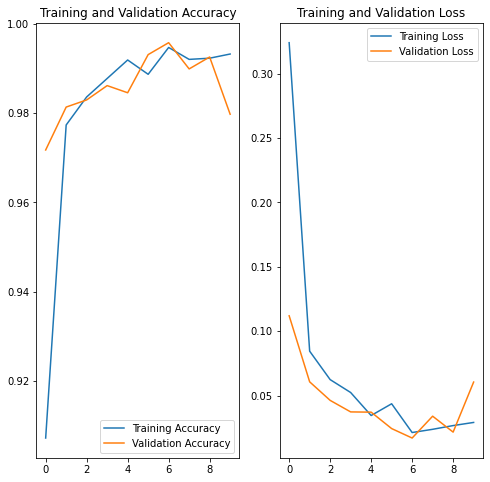

In [ ]:
acc = history.history['acc']
val_acc = history.history['val_acc']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(10)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()


In [ ]:

#%tensorboard --logdir logs/fit # this tensorboard portrays the visualzations above, but looks better and is interactive.

In [ ]:
## load the model with the best weights 


# load model with the best weights that had the highet val_acc
model.load_weights('/tmp/checkpoint')

X_test_scaled = pd.DataFrame(X_test_scaled)
y_labels= pd.DataFrame(y_test,columns=["classes"])

ord_enc = OrdinalEncoder()
y_test = pd.DataFrame(ord_enc.fit_transform(y_labels),columns=["classes"])


## class labels = {unknown: 2, bebop_1: 0, Membo_1: 1}


In [ ]:
y_test.classes.value_counts()

2.0    2067
1.0     148
0.0     126
Name: classes, dtype: int64

In [ ]:
accuracy = model.evaluate(X_test_scaled, y_test) 
print('Accuracy: %.2f' % (accuracy[1]*100)) 

74/74 [==============================] - 0s 2ms/step - loss: 0.0437 - acc: 0.9902
Accuracy: 99.02


# Things to Try:





*   Shapely Charts
*   List item
*   List item
*   List item






